In [1]:
import findspark
findspark.init()

In [2]:
%matplotlib inline
from __future__ import print_function
import os
import sys
import ast
import json
import re
import string
import requests
import matplotlib.pyplot as plt
import threading
import queue as Queue
import time
import requests_oauthlib
#import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import multiprocessing
from collections import Counter
from pyspark import SparkContext
from pyspark import SQLContext,Row
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.ml.feature import HashingTF,IDF, Tokenizer
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import StreamingKMeans
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.feature import Word2VecModel

In [3]:
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import Tree
import geocoder

In [4]:

BATCH_INTERVAL = 10  # How frequently to update (seconds)
WINDOWS_LENGTH=60  #the duration of the window
SLIDING_INTERVAL=20 #the interval at which the window operation is performed
clusterNum=15 #Number of CLusters

from IPython import display

def data_plotting(q,f):
    print("starting plot")
    #%matplotlib inline
    plt.ion() # Interactive mode
    llon = -140
    ulon = 140
    llat = -50
    ulat = 70
    rcParams['figure.figsize'] = (14,10)
    my_map = Basemap(projection='merc',
                resolution = 'l', area_thresh = 1000.0,
                llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
                urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

    my_map.drawcoastlines()
    my_map.drawcountries()
    my_map.drawmapboundary()
    my_map.fillcontinents(color = 'white', alpha = 0.3)
    #my_map.shadedrelief()

    time.sleep(1.0)
    plt.pause(0.0001)
    display.clear_output(wait=True)
    display.display(plt.gcf())

    colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

    while True:
        if q.empty():
            xs,ys = my_map(0, 0)
            my_map.scatter(xs, ys,  marker='o',  alpha = 1.0,color=colors[np.random.random_integers(5)])
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(5)
            
        else:
            obj=q.get()
            d=[x[0][0] for x in obj]
            c=[x[1] for x in obj]
            data = np.array(d)
            pcolor=np.array(c)
            print(c)
            try:
                xs,ys = my_map(data[:, 0], data[:, 1])
                my_map.scatter(xs, ys,  marker='o', alpha = 0.5,color=colors[pcolor])
                plt.pause(0.0001)
                plt.draw()
                display.clear_output(wait=True)
                display.display(plt.gcf())
                time.sleep(5)
                
            except IndexError: # Empty array
                pass

#             if not f.empty():
#                 objtopic=f.get() #(11, ([-49.261209, -16.6427825], [('phlima07', 1), ('dm', 1), ('ouuu', 1)]))
#                 for row in objtopic:
#                     #print(row)
#                     xc,yc=my_map(row[1][0][0], row[1][0][1])
#                     #print (xc)
#                     clus=row[0]
#                     #ptext[clus].set_text(str(clus)+ ':'+str([x[0] for x in row[1][1]]))
#                     ptext[clus].set_text(str(clus)+ ':'+str(row[1][1]))
#                     ptext[clus].set_color(colors[clus])
#                 plt.pause(0.0001)

'''
def get_coord2(post):
    coord = tuple()
    try:
        if post['coordinates'] == None:
            coord = post['place']['bounding_box']['coordinates']
            coord = reduce(lambda agg, nxt: [agg[0] + nxt[0], agg[1] + nxt[1]], coord[0])
            coord = tuple(map(lambda t: t / 4.0, coord))
        else:
            coord = tuple(post['coordinates']['coordinates'])
    except TypeError:
        #print ('error get_coord')
        coord=(0,0)
    return coord
'''
def get_coord(post):
    coord = tuple()
    g = geocoder.geonames(post,key="ragulaaryan")
    try:
        if len(post)==0:
            coord = (0,0)
        else:
            coord = (float(g.lat),float(g.lng))
    except TypeError:
        #print ('error get_coord')
        coord=(0,0)
    return coord

def get_location(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() == "GPE":
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
            
    
    place=[]
    location=()
    if len(continuous_chunk)==0:
        location=(0,0)
        return location
    else:
        for item in range(len(continuous_chunk)):
            location=get_coord(continuous_chunk[item])
            return location
            break


def get_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return json_object


def doc2vec(document):
    doc_vec = np.zeros(100)
    tot_words = 0

    for word in document:
        try:
            vec = np.array(lookup_bd.value.get(word))
            if vec!= None:
                doc_vec +=  vec
                tot_words += 1
        except:
            continue

    #return(tot_words)
    return doc_vec / float(tot_words)

remove_spl_char_regex = re.compile('[%s]' % re.escape(string.punctuation)) # regex to remove special characters
stopwords=[u'rt', u're', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don', u'should', u'now']
def tokenize(text):
    tokens = []
    #text = text.encode('ascii', 'ignore') #to decode
    text=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # to replace url with ''
    text = remove_spl_char_regex.sub(" ",text)  # Remove special characters
    text=text.lower()


    for word in text.split():
        if word not in stopwords \
            and word not in string.punctuation \
            and len(word)>1 \
            and word != '``':
                tokens.append(word)
    return tokens


def freqcount(terms_all):
    count_all = Counter()
    count_all.update(terms_all)
    return count_all.most_common(5)

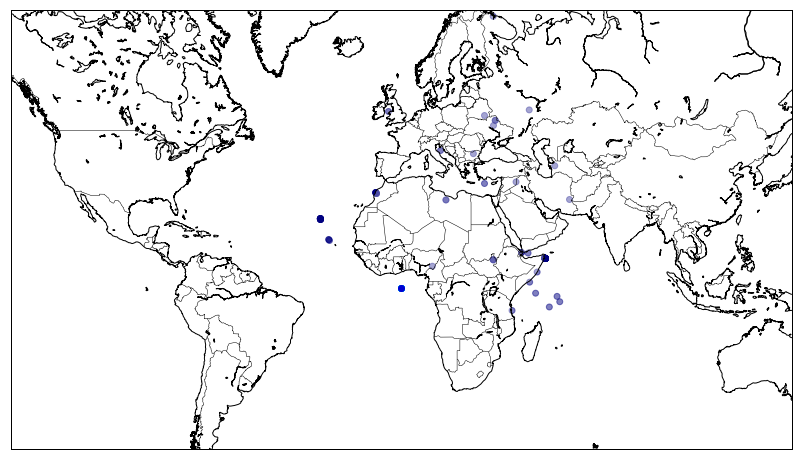

KeyboardInterrupt: 

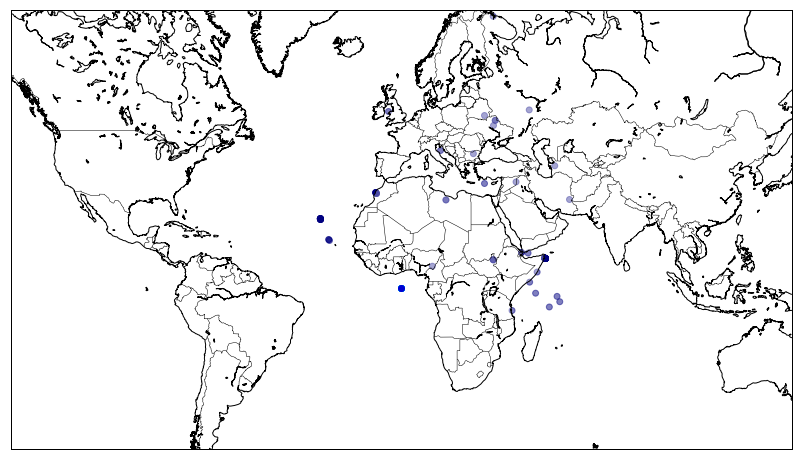

In [5]:
import threading
import queue as Queue
import time
threads = []
q = Queue.Queue()
f = Queue.Queue()
# Set up spark objects and run
sc = SparkContext.getOrCreate();
#sc = SparkContext(appName="disasterwithtweet")
sc.setLogLevel("ERROR")
#threads.append(threading.Thread(target=test1, args=()))
threads.append(threading.Thread(target=data_plotting, args=(q,f)))
[t.start() for t in threads]
#To load Word2Vec model in a low cost manner, we use a Broadcast variable to keep the model on each machine as
# a cached and read-only variable, rather than shipping a copy of it with tasks.
# It will give every node a copy of the model efficiently.
sqlContext=SQLContext(sc)
lookup = sqlContext.read.parquet("resources/word2vector_model/data").alias("word2vec_model")
lookup.printSchema()
lookup_bd = sc.broadcast(lookup.rdd.collectAsMap())

#To setup the streaming data
ssc = StreamingContext(sc, BATCH_INTERVAL)
#ssc.checkpoint("checkpoint")


# Create a DStream that will connect to hostname:port, like localhost:9999
dstream = ssc.socketTextStream("localhost", 7878)
#dstreamwin=dstream.window(WINDOWS_LENGTH, SLIDING_INTERVAL)
dstream_tweets=dstream.map(lambda post: get_json(post))\
     .filter(lambda post: post != False)\
     .filter(lambda post: 'created_at' in post)\
     .map(lambda post: (get_location(post["text"])[0],get_location(post["text"])[1],post["text"]))\
     .filter(lambda tpl: tpl[0] != 0)\
     .filter(lambda tpl: tpl[2] != '')\
     .map(lambda tpl: (tpl[0],tpl[1],tokenize(tpl[2])))\
     .map(lambda tpl:(tpl[0],tpl[1],tpl[2],doc2vec(tpl[2])))
#dstream_tweets.pprint()


trainingData=dstream_tweets.map(lambda tpl: [tpl[0],tpl[1]]+tpl[3].tolist())
#trainingData.pprint()
testdata=dstream_tweets.map(lambda tpl: (([tpl[0],tpl[1]],tpl[2]),[tpl[0],tpl[1]]+tpl[3].tolist()))
#testdata.pprint()

model = StreamingKMeans(k=clusterNum, decayFactor=0.6).setRandomCenters(102, 1.0, 3)
model.trainOn(trainingData)
clust=model.predictOnValues(testdata)
#print (model.latestModel().clusterCenters[0])
#clust.pprint()

topic=clust.map(lambda x: (x[1],x[0][1]))
#topic.pprint()
# runningTopics = topic.updateStateByKey(updateFunction)
# runningTopics.pprint()
topicAgg = topic.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],freqcount(x[1])))
#topicAgg.pprint()

coord=clust.map(lambda x: (x[1],x[0][0]))
coordAgg=coord.reduceByKey(lambda x,y: [x[0]+y[0],x[1]+y[1]])
#coordAgg.pprint()

count=clust.map(lambda x: (x[1],1))
countAgg=count.reduceByKey(lambda x,y: x+y)
#countAgg.pprint()
print ("----------------------------------------")
textdata=coordAgg.join(countAgg).mapValues(lambda x: [x[0][0]/float(x[1]),x[0][1]/float(x[1])]).join(topicAgg)
textdata.pprint()


clust.foreachRDD(lambda time, rdd: q.put(rdd.collect()))
textdata.foreachRDD(lambda time, rdd: f.put(rdd.collect()))


# Run!
ssc.start()
#data_plotting(q,f)
ssc.awaitTermination()


In [ ]:

%matplotlib inline
from __future__ import print_function
import os
import sys
import ast
import json
import re
import string
import requests
import matplotlib.pyplot as plt
import threading
from multiprocessing import Queue
import time
import requests_oauthlib
#import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import multiprocessing
from collections import Counter
from pyspark import SparkContext
from pyspark import SQLContext,Row
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils 
from pyspark.ml.feature import HashingTF,IDF, Tokenizer
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import StreamingKMeans
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.feature import Word2VecModel


In [31]:
BATCH_INTERVAL = 10  # How frequently to update (seconds)
WINDOWS_LENGTH=60  #the duration of the window
SLIDING_INTERVAL=20 #the interval at which the window operation is performed
clusterNum=15 #Number of CLusters

from IPython import display

def data_plotting(q,f):
    print("starting plot")
    #%matplotlib inline
    plt.ion() # Interactive mode
    llon = -140
    ulon = 140
    llat = -50
    ulat = 70
    rcParams['figure.figsize'] = (14,10)
    my_map = Basemap(projection='merc',
                resolution = 'l', area_thresh = 1000.0,
                llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
                urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

    my_map.drawcoastlines()
    my_map.drawcountries()
    my_map.drawmapboundary()
    my_map.fillcontinents(color = 'white', alpha = 0.3)
    #my_map.shadedrelief()

    time.sleep(1.0)
    plt.pause(0.0001)
    display.clear_output(wait=True)
    display.display(plt.gcf())

    colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))

    while True:
        if q.empty():
            xs,ys = my_map(0, 0)
            my_map.scatter(xs, ys,  marker='o',  alpha = 1.0,color=colors[np.random.random_integers(5)])
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(5)
            
        else:
            obj=q.get()
            d=[x[0][0] for x in obj]
            c=[x[1] for x in obj]
            data = np.array(d)
            pcolor=np.array(c)
            print(c)
            try:
                xs,ys = my_map(data[:, 0], data[:, 1])
                my_map.scatter(xs, ys,  marker='o', alpha = 0.5,color=colors[pcolor])
                plt.pause(0.0001)
                plt.draw()
                display.clear_output(wait=True)
                display.display(plt.gcf())
                time.sleep(5)
                
            except IndexError: # Empty array
                pass

#             if not f.empty():
#                 objtopic=f.get() #(11, ([-49.261209, -16.6427825], [('phlima07', 1), ('dm', 1), ('ouuu', 1)]))
#                 for row in objtopic:
#                     #print(row)
#                     xc,yc=my_map(row[1][0][0], row[1][0][1])
#                     #print (xc)
#                     clus=row[0]
#                     #ptext[clus].set_text(str(clus)+ ':'+str([x[0] for x in row[1][1]]))
#                     ptext[clus].set_text(str(clus)+ ':'+str(row[1][1]))
#                     ptext[clus].set_color(colors[clus])
#                 plt.pause(0.0001)


def get_coord2(post):
    coord = tuple()
    try:
        if post['coordinates'] == None:
            coord = post['place']['bounding_box']['coordinates']
            coord = reduce(lambda agg, nxt: [agg[0] + nxt[0], agg[1] + nxt[1]], coord[0])
            coord = tuple(map(lambda t: t / 4.0, coord))
        else:
            coord = tuple(post['coordinates']['coordinates'])
    except TypeError:
        #print ('error get_coord')
        coord=(0,0)
    return coord


def get_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return json_object


def doc2vec(document):
    doc_vec = np.zeros(100)
    tot_words = 0

    for word in document:
        try:
            vec = np.array(lookup_bd.value.get(word))
            if vec!= None:
                doc_vec +=  vec
                tot_words += 1
        except:
            continue

    #return(tot_words)
    return doc_vec / float(tot_words)

remove_spl_char_regex = re.compile('[%s]' % re.escape(string.punctuation)) # regex to remove special characters
stopwords=[u'rt', u're', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don', u'should', u'now']
def tokenize(text):
    tokens = []
    text = text.encode('ascii', 'ignore') #to decode
    text=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # to replace url with ''
    text = remove_spl_char_regex.sub(" ",text)  # Remove special characters
    text=text.lower()


    for word in text.split():
        if word not in stopwords \
            and word not in string.punctuation \
            and len(word)>1 \
            and word != '``':
                tokens.append(word)
    return tokens


def freqcount(terms_all):
    count_all = Counter()
    count_all.update(terms_all)

    return count_all.most_common(5)

#sc = SparkContext.getOrCreate();
sc = SparkContext.getOrCreate();
#sc = SparkContext(appName="disasterwithtweet")
sc.setLogLevel("ERROR")
windowIntervalSecs = 10
ssc = StreamingContext(sc, windowIntervalSecs)

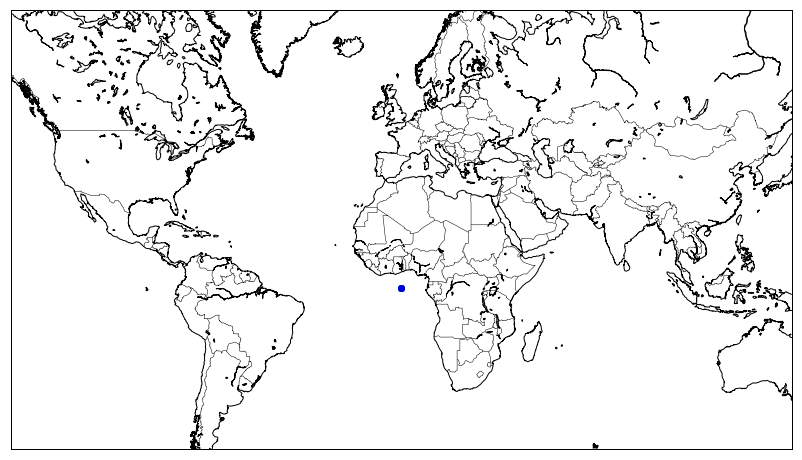

In [33]:
import threading
import queue as Queue
import time
threads = []
q = Queue.Queue()
f = Queue.Queue()
# Set up spark objects and run
#threads.append(threading.Thread(target=test1, args=()))
threads.append(threading.Thread(target=data_plotting, args=(q,f)))
[t.start() for t in threads]
#To load Word2Vec model in a low cost manner, we use a Broadcast variable to keep the model on each machine as
# a cached and read-only variable, rather than shipping a copy of it with tasks.
# It will give every node a copy of the model efficiently.
sqlContext=SQLContext(sc)
lookup = sqlContext.read.parquet("../word2vecModel/data").alias("lookup")
lookup.printSchema()
lookup_bd = sc.broadcast(lookup.rdd.collectAsMap())

#To setup the streaming data
ssc = StreamingContext(sc, BATCH_INTERVAL)
#ssc.checkpoint("checkpoint")



# Create a DStream that will connect to hostname:port, like localhost:9999
dstream = ssc.socketTextStream("localhost", 9995)
#dstreamwin=dstream.window(WINDOWS_LENGTH, SLIDING_INTERVAL)
dstream_tweets=dstream.map(lambda post: get_json(post))\
     .filter(lambda post: post != False)\
     .filter(lambda post: 'created_at' in post)\
     .map(lambda post: (get_coord2(post)[0],get_coord2(post)[1],post["text"]))\
     .filter(lambda tpl: tpl[0] != 0)\
     .filter(lambda tpl: tpl[2] != '')\
     .map(lambda tpl: (tpl[0],tpl[1],tokenize(tpl[2])))\
     .map(lambda tpl:(tpl[0],tpl[1],tpl[2],doc2vec(tpl[2])))
#dstream_tweets.pprint()


trainingData=dstream_tweets.map(lambda tpl: [tpl[0],tpl[1]]+tpl[3].tolist())
#trainingData.pprint()
testdata=dstream_tweets.map(lambda tpl: (([tpl[0],tpl[1]],tpl[2]),[tpl[0],tpl[1]]+tpl[3].tolist()))
#testdata.pprint()

model = StreamingKMeans(k=clusterNum, decayFactor=0.6).setRandomCenters(102, 1.0, 3)
model.trainOn(trainingData)
clust=model.predictOnValues(testdata)
#print (model.latestModel().clusterCenters[0])
#clust.pprint()

topic=clust.map(lambda x: (x[1],x[0][1]))
#topic.pprint()
# runningTopics = topic.updateStateByKey(updateFunction)
# runningTopics.pprint()
topicAgg = topic.reduceByKey(lambda x,y: x+y).map(lambda x: (x[0],freqcount(x[1])))
#topicAgg.pprint()

coord=clust.map(lambda x: (x[1],x[0][0]))
coordAgg=coord.reduceByKey(lambda x,y: [x[0]+y[0],x[1]+y[1]])
#coordAgg.pprint()

count=clust.map(lambda x: (x[1],1))
countAgg=count.reduceByKey(lambda x,y: x+y)
#countAgg.pprint()
print ("----------------------------------------")
textdata=coordAgg.join(countAgg).mapValues(lambda x: [x[0][0]/float(x[1]),x[0][1]/float(x[1])]).join(topicAgg)
textdata.pprint()


clust.foreachRDD(lambda time, rdd: q.put(rdd.collect()))
textdata.foreachRDD(lambda time, rdd: f.put(rdd.collect()))


# Run!
ssc.start()
#data_plotting(q,f)
ssc.awaitTermination()


In [2]:
import findspark
findspark.init()

In [3]:
from pyspark import SparkContext
from pyspark import SparkConf
from __future__ import print_function
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
import sys
import json
import time
from pyspark.sql import SQLContext

In [4]:
from pyspark import SparkContext
from pyspark import SQLContext,Row
from pyspark.streaming import StreamingContext
from pyspark.ml.feature import HashingTF,IDF, Tokenizer
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import StreamingKMeans
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.feature import Word2VecModel

In [7]:
import threading
import queue
import time

import re

In [11]:
def doc2vec(document):
    doc_vec = np.zeros(100)
    tot_words = 0

    for word in document:
        try:
            vec = np.array(lookup_bd.value.get(word))
            if vec!= None:
                doc_vec +=  vec
                tot_words += 1
        except:
            continue

    #return(tot_words)
    return doc_vec / float(tot_words)

remove_spl_char_regex = re.compile('[%s]' % re.escape(string.punctuation)) # regex to remove special characters
stopwords=[u'rt', u're', u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u'not', u'only', u'own', u'same', u'so', u'than', u'too', u'very', u's', u't', u'can', u'will', u'just', u'don', u'should', u'now']
def tokenize(text):
    tokens = []
    text = text.encode('ascii', 'ignore') #to decode
    text=re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*(),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) # to replace url with ''
    text = remove_spl_char_regex.sub(" ",text)  # Remove special characters
    text=text.lower()


    for word in text.split():
        if word not in stopwords \
            and word not in string.punctuation \
            and len(word)>1 \
            and word != '``':
                tokens.append(word)
    return tokens


def freqcount(terms_all):
    count_all = Counter()
    count_all.update(terms_all)
    return count_all.most_common(5)

In [12]:
BATCH_INTERVAL = 10  # How frequently to update (seconds)
WINDOWS_LENGTH=60  #the duration of the window
SLIDING_INTERVAL=20 #the interval at which the window operation is performed
clusterNum=15 #Number of CLusters

from IPython import display

In [13]:
#sc = SparkContext.getOrCreate();
sc = SparkContext.getOrCreate();
#sc = SparkContext(appName="disasterwithtweet")
sc.setLogLevel("ERROR")
windowIntervalSecs = 10
ssc = StreamingContext(sc, windowIntervalSecs)

threads = []
q = queue.Queue()
f = queue.Queue()
#create sc
'''
# Set up spark objects and run
#threads.append(threading.Thread(target=test1, args=()))
threads.append(threading.Thread(target=data_plotting, args=(q,f)))
[t.start() for t in threads]
#To load Word2Vec model in a low cost manner, we use a Broadcast variable to keep the model on each machine as
# a cached and read-only variable, rather than shipping a copy of it with tasks.
# It will give every node a copy of the model efficiently.
sqlContext=SQLContext(sc)
lookup = sqlContext.read.parquet("/resources/word2vecModel/data").alias("lookup")
lookup.printSchema()
lookup_bd = sc.broadcast(lookup.rdd.collectAsMap())'''

#To setup the streaming data
#ssc = StreamingContext(sc, BATCH_INTERVAL)
#ssc.checkpoint("checkpoint")

In [14]:
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import Tree

def get_continuous_chunks(text):
    chunked = ne_chunk(pos_tag(word_tokenize(text)))
    prev = None
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree and subtree.label() == "GPE":
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk